In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
import string
import collections
import os
import nltk

from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import *

Using TensorFlow backend.
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
data = pd.read_csv(".\dataset 2\dataset.csv")
data.head()

,Text
0,News: GRECCO-19 trial results reported by Spyr...
1,@WhiteHouse @trumprealtweets @Forbes @YahooNew...
2,@realDonaldTrump Record #covid19 cases! #VoteB...
3,@JanJan60206902 Don’t forget when trump shut d...
4,Is that Covid19 shit growing in new jersery or...


# Text Preprocessing

In [3]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [4]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [5]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [6]:
emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
tokens_list = []

In [8]:
stemmer = nltk.stem.PorterStemmer()

def clean_tweets(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','',tweet)     
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'https?:\/\/\S+','',tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)       
    tweet = rpt_regex.sub(r"\1\1", tweet)               # Repeating words like sadddd                                       
    
    
    tweet_stem = ''
    words = [word if(word[0:2]=='__') else word.lower() \
                for word in tweet.split() \
                if len(word) >= 3]
    words = [stemmer.stem(w) for w in words] 
    tweet_stem = ' '.join(words)
    tweet = tweet_stem
    
    #make a list of stopwords
    stopw = set(stopwords.words('english'))
    stopw.remove('not')
    stopw.remove('nor')

    #make word tokens
    tokenizer = RegexpTokenizer('[a-zA-Z]+')
    word_tokens = tokenizer.tokenize(tweet.lower())
     
    #remove stopwords    
    filtered_tweet = [w for w in word_tokens if not w in stopw]
    filtered_tweet = []
    
    #looping through conditions
    for w in word_tokens:

        #check tokens against stop words , emoticons and punctuations
        if w not in stopw and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
            
    tokens_list.append(filtered_tweet)
    return ' '.join(filtered_tweet)

In [9]:
filtered_tweets = []

for i in range(len(data)):
    filtered_tweets.append(clean_tweets(data["Text"][i]))
    
print(filtered_tweets)

['news grecco trial result report spyridon deftereo co author', 'time get real time call right need', 'record covid cases votebluetosaveamerica voteblu resignnowtrump', 'forget trump shut intern travel becaus covid democrat call', 'covid shit grow new jerseri not need answerss', 'one left behind covid response need support migrant worker prioriti right', 'chairman adam schiff usa congress intellig committe juli covid usa wha', 'hey v indoor becaus covid', 'absolut unnecessari divert time resourc toward pvnarasimharao centenari celebrati', 'california close mani beach go shut indoor oper mani busin', 'arizona governor shut order defi reason', 'countri across world particularli dure covid pandemic wit limit healthcar', 'mani comment expect senior team communications includ thi one north', 'tangina plss miss skin thi fuck household know word affect covid', 'arizona covid report confirm case daili case confirm death new death', 'trump still downplay covid reach highest number daili infect 

In [10]:
tokens = np.array(tokens_list)
print(tokens.shape)
print(type(tokens))

(18753,)
<class 'numpy.ndarray'>


In [11]:
tweet_df = np.column_stack((filtered_tweets, tokens))

In [12]:
tweet_df.shape

(18753, 2)

In [13]:
tweet_df = pd.DataFrame(data=tweet_df,columns=['Text','Tokens'])
tweet_df.head()


,Text,Tokens
0,news grecco trial result report spyridon defte...,"[news, grecco, trial, result, report, spyridon..."
1,time get real time call right need,"[time, get, real, time, call, right, need]"
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ..."
3,forget trump shut intern travel becaus covid d...,"[forget, trump, shut, intern, travel, becaus, ..."
4,covid shit grow new jerseri not need answerss,"[covid, shit, grow, new, jerseri, not, need, a..."


In [14]:
# finding polarity of text using textBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweet_df['Polarity'] = tweet_df['Text'].apply(getPolarity)
tweet_df

,Text,Tokens,Polarity
0,news grecco trial result report spyridon defte...,"[news, grecco, trial, result, report, spyridon...",0.000000
1,time get real time call right need,"[time, get, real, time, call, right, need]",0.242857
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ...",0.000000
3,forget trump shut intern travel becaus covid d...,"[forget, trump, shut, intern, travel, becaus, ...",0.000000
4,covid shit grow new jerseri not need answerss,"[covid, shit, grow, new, jerseri, not, need, a...",-0.031818
...,...,...,...
18748,close garment worker test posit coronavirus lo...,"[close, garment, worker, test, posit, coronavi...",0.000000
18749,close garment worker test posit coronavirus lo...,"[close, garment, worker, test, posit, coronavi...",0.000000
18750,coronaviru go away fact spike dramat state rep...,"[coronaviru, go, away, fact, spike, dramat, st...",0.000000
18751,appreci r use data r also base ass,"[appreci, r, use, data, r, also, base, ass]",-0.800000


In [15]:
tweet_df.shape

(18753, 3)

In [16]:
tweet_df.Polarity.unique()

array([ 0.00000000e+00,  2.42857143e-01, -3.18181818e-02, -3.80952381e-02,
       -4.00000000e-01,  1.36363636e-01,  8.00000000e-01,  3.50000000e-01,
       -4.66666667e-01, -1.25000000e-01, -6.25000000e-02, -6.81818182e-02,
       -2.33333333e-01, -1.00000000e-01,  4.54545455e-02,  4.00000000e-01,
        5.00000000e-01,  2.50000000e-01,  2.00000000e-01, -5.00000000e-01,
        5.00000000e-02, -1.66666667e-01,  1.60000000e-01, -8.00000000e-01,
       -2.91666667e-01, -1.16666667e-01, -1.04166667e-01,  1.27083333e-01,
        1.00000000e-01,  6.81818182e-02,  1.00000000e+00, -8.00000000e-01,
        4.50000000e-01,  5.00000000e-02,  1.66666667e-01, -1.75000000e-01,
       -1.25000000e-02,  4.16666667e-01, -5.35714286e-02,  7.87878788e-02,
        2.50000000e-02,  1.82954545e-01, -1.00000000e+00, -6.00000000e-01,
        2.85714286e-01, -1.08333333e-01, -2.00000000e-01,  2.16666667e-01,
        1.78571429e-01,  7.00000000e-01,  2.08333333e-02, -3.00000000e-01,
        1.50000000e-01, -

In [17]:
pos = []
neg = []
polarity = []
countp = 0
countn = 0
count = 0

for i in tweet_df.Polarity:
    if i < 0:
        polarity.append(0)
        pos.append(0)
        neg.append(1)
        countn += 1
    elif i >= 0:
        polarity.append(1)
        pos.append(1)
        neg.append(0)
        countp += 1
    

print(countp,countn)

15885 2868


In [18]:
tweet_df['Pos']= pos
tweet_df['Neg']= neg
tweet_df['Polarity'] = polarity

In [19]:
#clean data is ready with tokens and polarity

tweet_df.head()

,Text,Tokens,Polarity,Pos,Neg
0,news grecco trial result report spyridon defte...,"[news, grecco, trial, result, report, spyridon...",1,1,0
1,time get real time call right need,"[time, get, real, time, call, right, need]",1,1,0
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ...",1,1,0
3,forget trump shut intern travel becaus covid d...,"[forget, trump, shut, intern, travel, becaus, ...",1,1,0
4,covid shit grow new jerseri not need answerss,"[covid, shit, grow, new, jerseri, not, need, a...",0,0,1


In [20]:
#tweet_df.to_csv('new_train.csv', index=False)

# Data visulisation

In [21]:
from wordcloud import WordCloud

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
neg_tweets = tweet_df[tweet_df.Polarity == 0]
neg_string = []
for t in neg_tweets.Text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


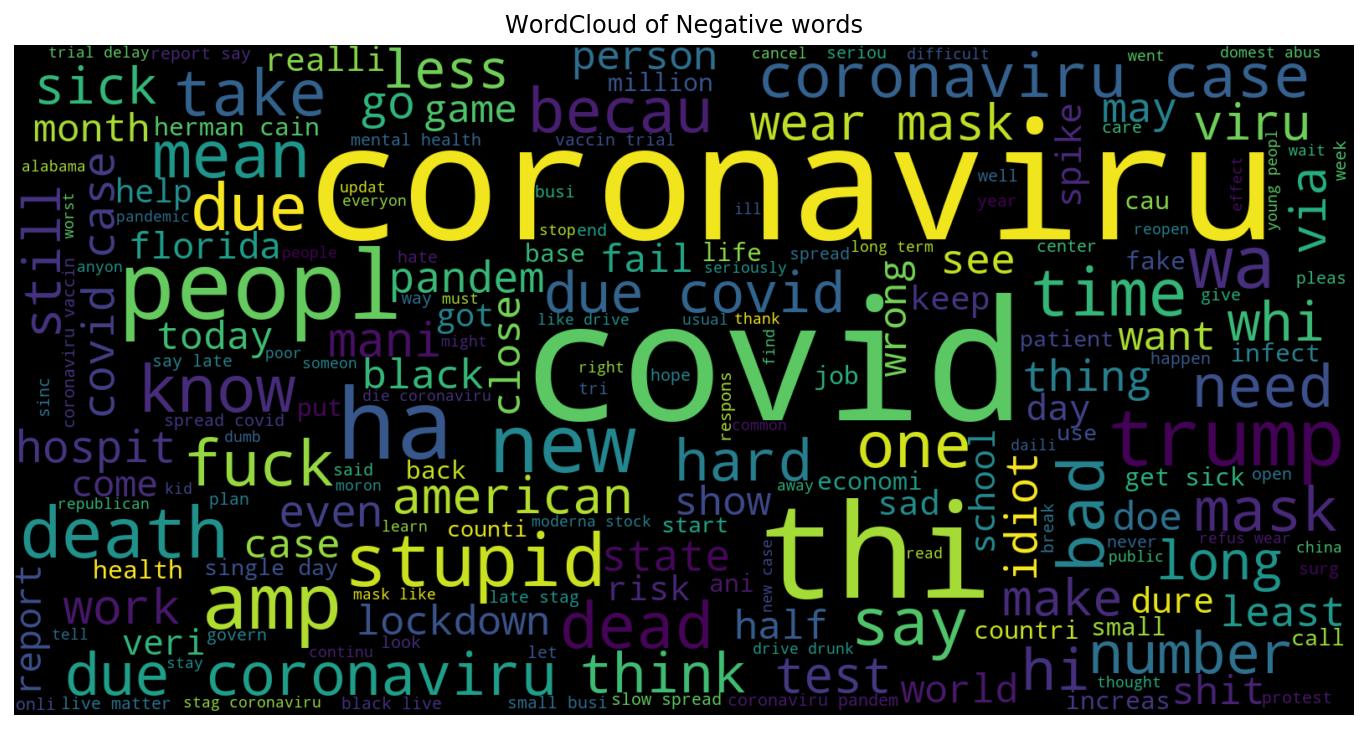

In [23]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Negative words")
plt.show()

In [24]:
pos_tweets = tweet_df[tweet_df.Polarity == 1]
pos_string = []
for t in pos_tweets.Text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

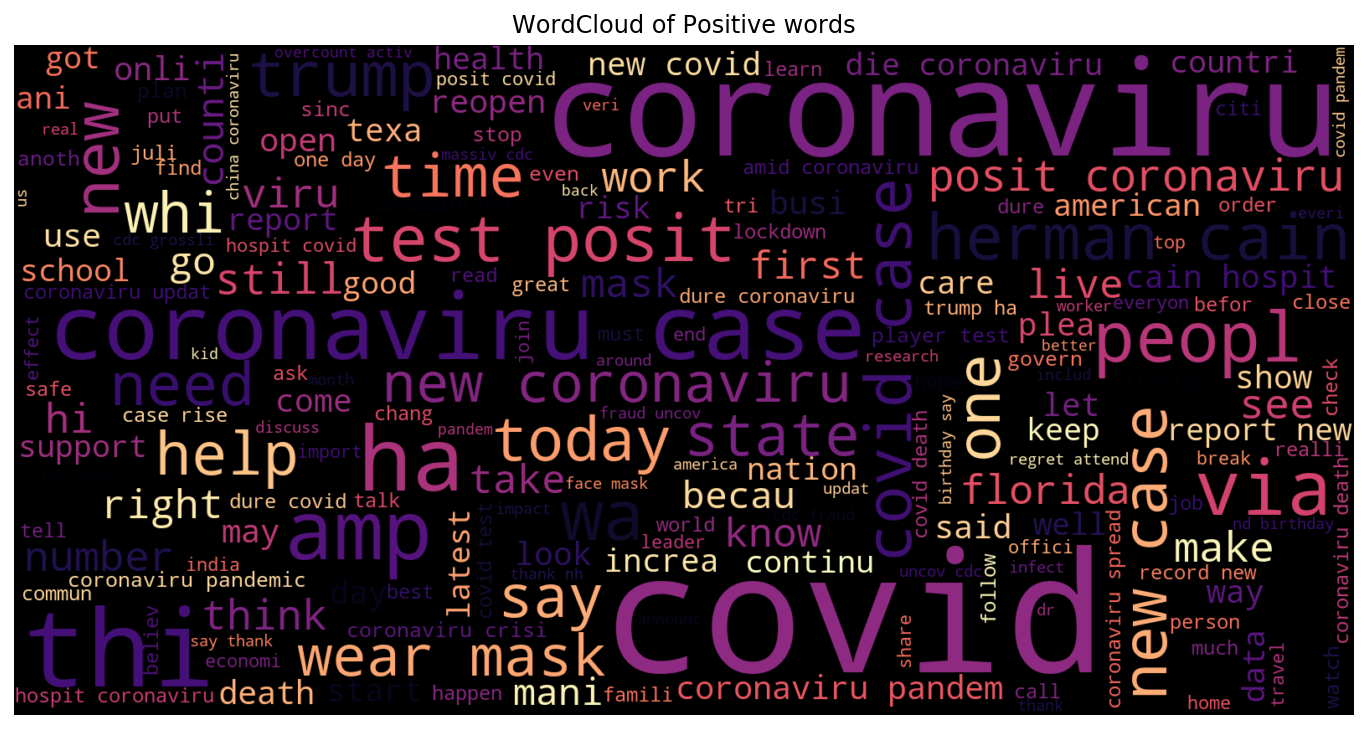

In [25]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Positive words")
plt.show()

# Splitting data into training data and test data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
data_train, data_test = train_test_split(tweet_df,test_size=0.10,random_state=42)

In [131]:
#  training data

all_training_words = [word for tokens in data_train['Tokens'] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train['Tokens']]
training_vocab = sorted(list(set(all_training_words)))
print("Total words = %s " % (len(all_training_words)))
print("Vocabulary size = %s "%(len(training_vocab)))
print("Max sentence length = %s" % max(training_sentence_lengths))

Total words = 158728 
Vocabulary size = 15941 
Max sentence length = 20


In [130]:
# test data

all_test_words = [word for tokens in data_test['Tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['Tokens']]
test_vocab = sorted(list(set(all_test_words)))
print("Total words = %s " % (len(all_test_words)))
print("Vocabulary size = %s "%(len(test_vocab)))
print("Max sentence length = %s" % max(test_sentence_lengths))

Total words = 17421 
Vocabulary size = 4591 
Max sentence length = 17


## Load Google News Word2Vec model

In [132]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [133]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

## Get Embeddings

In [134]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [135]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

## Tokenizing and Pad Sequences

In [159]:
tokenizer = Tokenizer(num_words=len(training_embeddings), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 15941 unique tokens.


In [160]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [161]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(15942, 300)


In [162]:

test_sequences = tokenizer.texts_to_sequences(data_test["Text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## CNN model

In [163]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [164]:
label_names = ['Pos', 'Neg']

In [165]:
y_train = data_train[label_names].values

In [166]:
x_train = train_cnn_data
y_tr = y_train

In [167]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,len(list(label_names)))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 300)      4782600     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 49, 200)      120200      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 48, 200)      180200      embedding_6[0][0]                
____________________________________________________________________________________________

In [168]:
# train cnn

num_epochs = 3  
batch_size = 20


In [169]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 15189 samples, validate on 1688 samples
Epoch 1/3
15189/15189 [==============================] - 124s 8ms/step - loss: 0.3772 - acc: 0.8612 - val_loss: 0.2613 - val_acc: 0.9023
Epoch 2/3
15189/15189 [==============================] - 122s 8ms/step - loss: 0.2167 - acc: 0.9185 - val_loss: 0.2278 - val_acc: 0.9067
Epoch 3/3
15189/15189 [==============================] - 118s 8ms/step - loss: 0.1216 - acc: 0.9545 - val_loss: 0.2190 - val_acc: 0.9292


## Test CNN

In [181]:
#test model

predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)


1876/1876 [==============================] - 5s 3ms/step


In [182]:
print(predictions)

[[9.9986559e-01 1.3434887e-04]
 [9.8680902e-01 1.4072984e-02]
 [9.9928248e-01 7.9649687e-04]
 ...
 [9.6728921e-01 3.5180628e-02]
 [9.9998534e-01 1.6242266e-05]
 [8.7948930e-01 1.3014263e-01]]


In [183]:
labels = [1, 0]

In [184]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

#print(prediction_labels)

In [185]:
sum(data_test.Polarity==prediction_labels)/len(prediction_labels)

0.9386993603411514

In [186]:
data_test.Polarity.value_counts()

1    1592
0     284
Name: Polarity, dtype: int64

In [187]:
# True Data

data_test['Polarity'].shape

(1876,)

In [188]:
from sklearn.metrics import confusion_matrix
from visualize import plot_confusion_matrix

In [189]:
result = confusion_matrix(data_test['Polarity'], prediction_labels)
print("Confusion MAtrix - ",result)

Confusion MAtrix -  [[ 200   84]
 [  31 1561]]


Confusion matrix, without normalization
[[ 200   84]
 [  31 1561]]


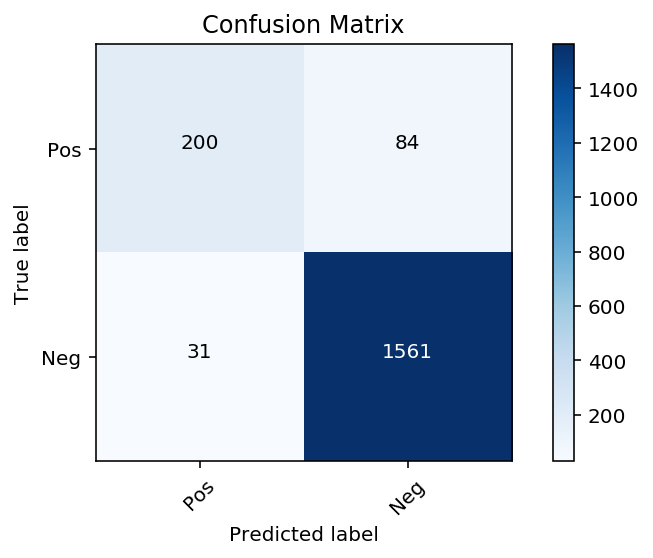

In [190]:
plot_confusion_matrix(result,classes =["Pos","Neg"],title = "Confusion Matrix")

In [193]:
# Some parameters using confusion matrix
TP = result[0][0]
FN = result[0][1]
FP = result[1][0]
TN = result[1][1]

Accuracy = (TP + TN) / (TP + TN + FP + FN)
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
Fmeasure = (2 * Recall * Precision) / (Recall + Precision)

print("Accuracy  : ", Accuracy)
print("Recall    : ", Recall)
print("Precision : ", Precision)
print("F-measure : ", Fmeasure)

Accuracy  :  0.9386993603411514
Recall    :  0.704225352112676
Precision :  0.8658008658008658
F-measure :  0.7766990291262136


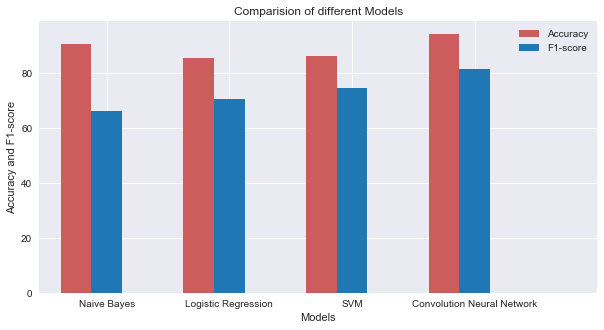

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[10,5])
# Data to be plotted
Accuracy = [90.43,85.32,86.11,94.24]
F1score = [66.33,70.61,74.5,81.55]
# Using numpy to group 3 different data with bars
X = np.arange(len(Accuracy))
# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side
plt.bar(X, Accuracy, color = 'indianred', width = 0.25,tick_label=True)
plt.bar(X + 0.25, F1score, color = 'tab:blue', width = 0.25,tick_label=True)
# Creating the legend of the bars in the plot
plt.legend(['Accuracy', 'F1-score'])
# Overiding the x axis with the model names
plt.xticks([i + 0.25 for i in range(5)], ["Naive Bayes","Logistic Regression","SVM","Convolution Neural Network"])
# Giving the tilte for the plot
plt.title("Comparision of different Models")
# Namimg the x and y axis
plt.xlabel('Models')
plt.ylabel('Accuracy and F1-score')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()